In [1]:
pip install tensorflow

  Using cached tensorflow-2.11.0-cp37-cp37m-win_amd64.whl (1.9 kB)
  Using cached tensorflow_intel-2.11.0-cp37-cp37m-win_amd64.whl (266.3 MB)
     -------------------------------------- 24.4/24.4 MB 543.8 kB/s eta 0:00:00
     ---------------------------------------- 1.5/1.5 MB 549.1 kB/s eta 0:00:00
     ------------------------------------ 126.5/126.5 kB 824.9 kB/s eta 0:00:00
     -------------------------------------- 65.5/65.5 kB 442.0 kB/s eta 0:00:00
     ------------------------------------ 439.2/439.2 kB 584.4 kB/s eta 0:00:00
     ---------------------------------------- 4.3/4.3 MB 546.1 kB/s eta 0:00:00
     ------------------------------------ 896.6/896.6 kB 540.5 kB/s eta 0:00:00
     ---------------------------------------- 6.0/6.0 MB 545.4 kB/s eta 0:00:00
     ---------------------------------------- 2.6/2.6 MB 549.6 kB/s eta 0:00:00
     ---------------------------------------- 57.5/57.5 kB 3.1 MB/s eta 0:00:00
     -------------------------------------- 94.2/94.2 kB 6

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


Found 1634 images for training belonging to 8 classes.
Found 810 images for testing belonging to 8 classes.
Epoch [1/50] Loss (Color): 1.0130
Test Loss (Color): 1.3106
Test Accuracy (Color): 86.30%
Epoch [2/50] Loss (Color): 0.4990
Test Loss (Color): 0.4685
Test Accuracy (Color): 91.98%
Epoch [3/50] Loss (Color): 0.3563
Test Loss (Color): 0.5166
Test Accuracy (Color): 92.10%
Epoch [4/50] Loss (Color): 0.3223
Test Loss (Color): 0.1979
Test Accuracy (Color): 92.47%
Epoch [5/50] Loss (Color): 0.2800
Test Loss (Color): 0.1478
Test Accuracy (Color): 92.59%
Epoch [6/50] Loss (Color): 0.2580
Test Loss (Color): 0.1452
Test Accuracy (Color): 93.95%
Epoch [7/50] Loss (Color): 0.2267
Test Loss (Color): 0.0580
Test Accuracy (Color): 93.46%
Epoch [8/50] Loss (Color): 0.2612
Test Loss (Color): 0.0435
Test Accuracy (Color): 92.72%
Epoch [9/50] Loss (Color): 0.2709
Test Loss (Color): 0.0677
Test Accuracy (Color): 94.07%
Epoch [10/50] Loss (Color): 0.2313
Test Loss (Color): 0.2119
Test Accuracy (Color)

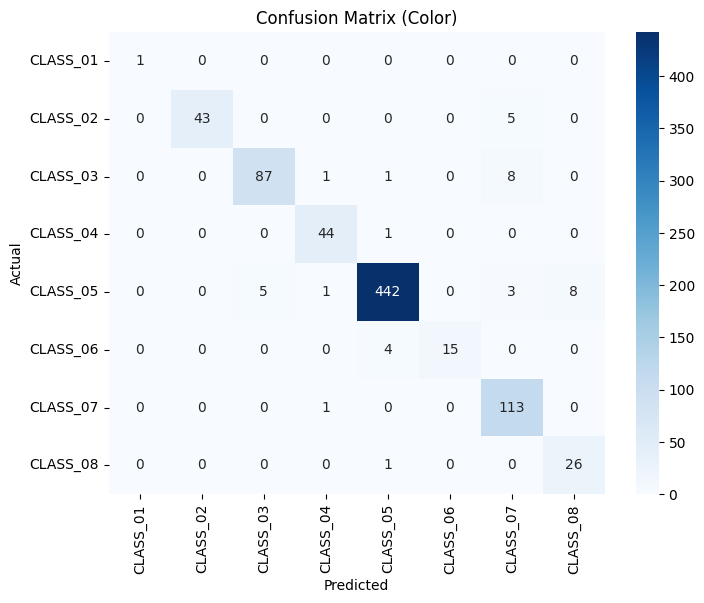

In [3]:
import torch       
import torch.nn as nn
from torchvision import transforms, datasets
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
from torchvision import models

# Define las rutas a las carpetas de datos de entrenamiento y prueba
train_data_dir = './train'
test_data_dir = './test'

# Define las transformaciones de aumento de datos para el conjunto de entrenamiento
data_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(30),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.RandomGrayscale(p=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


# Carga los datos de entrenamiento y prueba para imágenes en color
train_dataset_color = datasets.ImageFolder(train_data_dir, transform=data_transforms)
test_dataset_color = datasets.ImageFolder(test_data_dir, transform=data_transforms)



# Imprime la cantidad de imágenes encontradas y con las que se trabajará
print(f'Found {len(train_dataset_color)} images for training belonging to {len(train_dataset_color.classes)} classes.')
print(f'Found {len(test_dataset_color)} images for testing belonging to {len(test_dataset_color.classes)} classes.')

# Cargar el modelo preentrenado MobileNet
model_color = models.mobilenet_v2(pretrained=True)
# Congelar todas las capas del modelo MobileNet
for param in model_color.parameters():
    param.requires_grad = False

# Modificar la capa final para ajustar al número de clases en tu conjunto de datos
num_classes = len(train_dataset_color.classes)
model_color.classifier[1] = nn.Linear(model_color.classifier[1].in_features, num_classes)

# Define la función de pérdida y el optimizador para el modelo en color
criterion = nn.CrossEntropyLoss()
optimizer_color = torch.optim.Adam(model_color.classifier[1].parameters(), lr=0.001)

# Define el cargador de datos para el conjunto de prueba en color
train_loader = torch.utils.data.DataLoader(train_dataset_color, batch_size=32, shuffle=True)
# Crea el DataLoader para el conjunto de prueba en color
test_loader = torch.utils.data.DataLoader(test_dataset_color, batch_size=32, shuffle=False)


# Entrenamiento del modelo en color
num_epochs = 50
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_color.to(device)

train_losses = []
test_losses = []
train_accs = []
test_accs = []

for epoch in range(num_epochs):
    model_color.train()
    running_loss_color = 0.0

    for images_color, labels_color in train_loader:
        images_color, labels_color = images_color.to(device), labels_color.to(device)

        optimizer_color.zero_grad()

        outputs_color = model_color(images_color)
        loss_color = criterion(outputs_color, labels_color)

        loss_color.backward()
        optimizer_color.step()

        running_loss_color += loss_color.item()

    train_losses.append(running_loss_color / len(train_loader))
    
    # Evalúa el modelo en color en el conjunto de prueba
    model_color.eval()
    all_preds_color = []
    all_labels_color = []

    with torch.no_grad():
        for images_color, labels_color in test_loader:
            images_color, labels_color = images_color.to(device), labels_color.to(device)

            outputs_color = model_color(images_color)
            _, preds_color = torch.max(outputs_color, 1)

            all_preds_color.extend(preds_color.cpu().numpy())
            all_labels_color.extend(labels_color.cpu().numpy())

    test_loss_color = criterion(outputs_color, labels_color).item()
    test_acc_color = accuracy_score(all_labels_color, all_preds_color)

    test_losses.append(test_loss_color)
    test_accs.append(test_acc_color)

    print(f'Epoch [{epoch + 1}/{num_epochs}] Loss (Color): {train_losses[-1]:.4f}')
    print(f'Test Loss (Color): {test_losses[-1]:.4f}')
    print(f'Test Accuracy (Color): {test_accs[-1] * 100:.2f}%')

# Precisión en conjunto de entrenamiento
train_accuracy = accuracy_score(all_labels_color, all_preds_color)

print(f'Precisión en conjunto de entrenamiento (Color): {train_accuracy * 100:.2f}%')
print(f'Precisión en conjunto de prueba (Color): {test_accs[-1] * 100:.2f}%')

# Calcula y muestra la matriz de confusión
conf_matrix_color = confusion_matrix(all_labels_color, all_preds_color)
class_names = train_dataset_color.classes

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_color, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Color)')
plt.show()
